<a href="https://colab.research.google.com/github/FadelI/cophil-eq/blob/main/tutorials/tut01_okada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages
Uncomment the commands below to install the required packages for this tutorial.

In [1]:
# !pip install cutde
# !pip install okada_wrapper

# Use the Okada formulation to run surface dispplacement calculations for different earthquake scenarios

We willl start with the reverse fault.

Fault Length: 20000.0 m
Fault Width: 15000.0 m
Depth to Fault Center: 3749.9999999999995 m
Slip Vector (strike, dip, tensile): 0.000, 1.000, 0.000


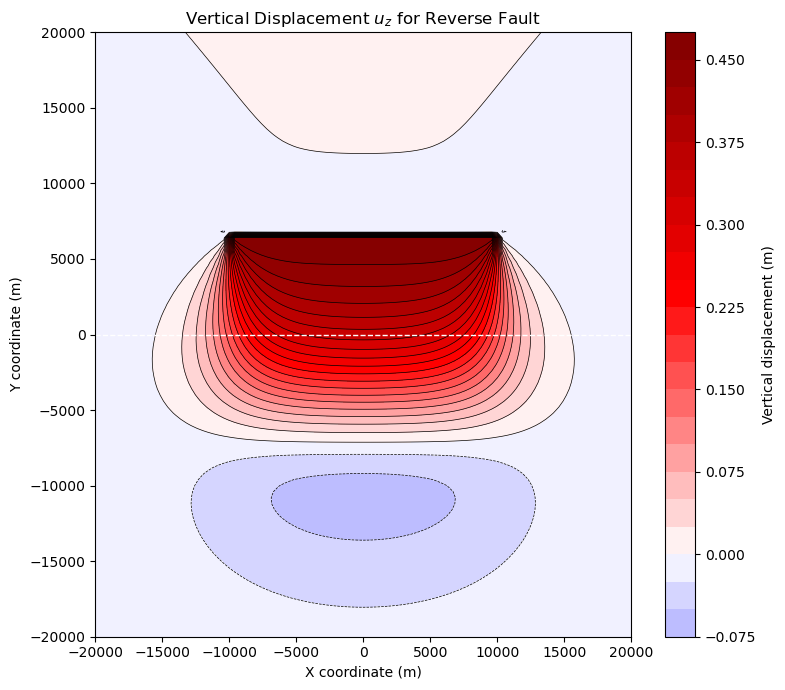

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import okada_wrapper

lambda_ = 3e10
mu = 3e10
alpha = (lambda_ + mu) / (lambda_ + 2 * mu)

# Fault parameters for a reverse (thrust) fault
strike = 90.0    # fault oriented E-W
dip = 30.0       # low-angle dipping fault
rake = 90.0      # slip is pure reverse/thrust (hanging wall up)
slip = 1.0

fault_length = 20000.0   # 20 km length
fault_width  = 15000.0   # 15 km along dip
# Depth to fault center (vertical)
vertical_extent = fault_width * np.sin(np.radians(dip))
depth = vertical_extent / 2.0  # center depth (top at surface)

# Slip vector from rake=90° (pure dip-slip up)
strike_slip = slip * np.cos(np.radians(rake))   # = 0
dip_slip    = slip * np.sin(np.radians(rake))   # = +1.0 (up-dip slip)
tensile_slip = 0.0
slip_vector = [strike_slip, dip_slip, tensile_slip]  # [0.0, 1.0, 0.0]

# Print fault parameters
print(f"Fault Length: {fault_length} m")
print(f"Fault Width: {fault_width} m")
print(f"Depth to Fault Center: {depth} m")

# Print slip vector with float formatting of 3 decimal places
print(f"Slip Vector (strike, dip, tensile): "
      f"{strike_slip:.3f}, {dip_slip:.3f}, {tensile_slip:.3f}")

# Observation grid
nobs = 101
X_range = 20000.0
Y_range = 20000.0
xs = np.linspace(-X_range, X_range, nobs)
ys = np.linspace(-Y_range, Y_range, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obs_pts = np.vstack([obsx.ravel(), obsy.ravel(), np.zeros_like(obsx).ravel()]).T

displacements = np.empty_like(obs_pts)
for i in range(obs_pts.shape[0]):
    success, U, _ = okada_wrapper.dc3dwrapper(
        alpha,
        obs_pts[i].tolist(),
        depth,
        dip,
        [-fault_length/2, fault_length/2],
        [-fault_width/2, fault_width/2],
        slip_vector
    )
    assert success == 0
    displacements[i] = U

disp_grid = displacements.reshape(nobs, nobs, 3)
e = disp_grid[:, :, 0]
n = disp_grid[:, :, 1]
u = disp_grid[:, :, 2]

# Plot vertical displacement for reverse fault
plt.figure(figsize=(8, 7))
levels = 21
cntf = plt.contourf(obsx, obsy, u, levels=levels, cmap='seismic',
                    vmin=-np.nanmax(np.abs(u)), vmax=np.nanmax(np.abs(u)))
plt.contour(obsx, obsy, u, levels=levels, colors='k', linewidths=0.5)
plt.colorbar(cntf, label="Vertical displacement (m)")
plt.title("Vertical Displacement $u_z$ for Reverse Fault")
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.axhline(0, color='w', linestyle='--', linewidth=1)  # fault trace at y=0
plt.tight_layout()
plt.show()

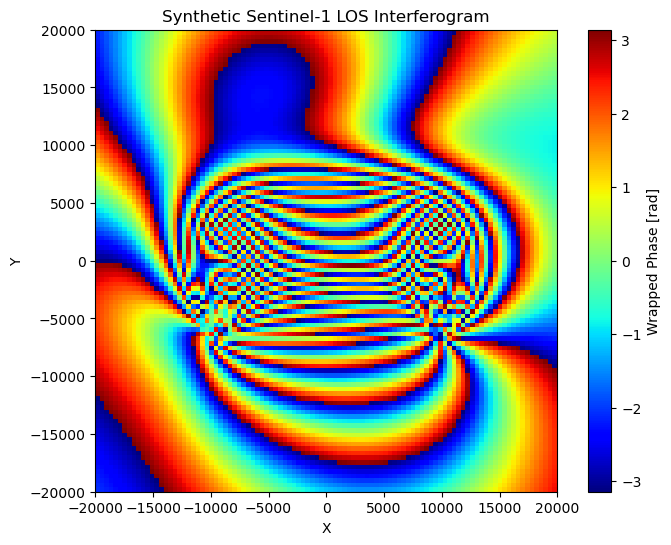

In [3]:
# Assume satellite geometry
theta_deg = 35       # Incidence angle
heading_deg = -135   # Heading angle
theta = np.deg2rad(theta_deg)
phi = np.deg2rad(90 - heading_deg)
wavelength_s1 = 0.055  # Sentinel-1 C-band wavelength in meters

# LOS vector components
los_vector = np.array([
    -np.sin(theta) * np.sin(phi),  # East
    -np.sin(theta) * np.cos(phi),  # North
    np.cos(theta)                  # Up
])

# LOS projection
los_disp = e * los_vector[0] + n * los_vector[1] + u * los_vector[2]

# Interferometric phase
phase = (4 * np.pi / wavelength_s1) * los_disp  # radians

# Optional: wrap phase to [-π, π]
wrapped_phase = np.angle(np.exp(1j * phase))

# Visualization
plt.figure(figsize=(8, 6))
plt.imshow(wrapped_phase, cmap='jet', extent=[-X_range, X_range, -Y_range, Y_range],
           vmin=-np.pi, vmax=np.pi)

plt.colorbar(label='Wrapped Phase [rad]')
plt.title('Synthetic Sentinel-1 LOS Interferogram')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Then we will simulate the strike-slip fault

Fault Length: 2000.0 m
Fault Width: 1000.0 m
Depth to Fault Center: 500.0 m
Slip Vector (strike, dip, tensile): 1.000, 0.000, 0.000


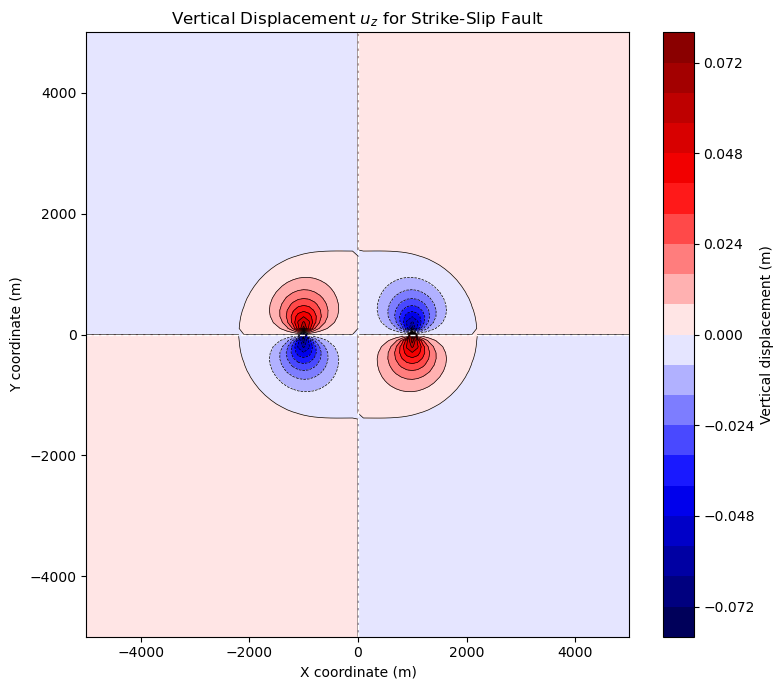

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import okada_wrapper

# Elastic material properties (for half-space): using Lame constants (Lambda, Mu)
lambda_ = 3e10  # Pa (Lame's first parameter, here set equal to mu for ν≈0.25)
mu = 3e10       # Pa (shear modulus)

# Okada's elastic constant alpha
alpha = (lambda_ + mu) / (lambda_ + 2 * mu)

# Fault parameters for a strike-slip fault
strike = 90.0    # fault strike orientation (degrees clockwise from North, here 90° = East-West)
dip = 89.999       # vertical fault
rake = 0.0       # slip rake angle (0° = purely strike-slip, right-lateral)
slip = 1.0       # slip magnitude in meters

fault_length = 2000.0   # total fault length in meters
fault_width  = 1000.0   # total fault width (down-dip extent) in meters
depth = fault_width / 2.0   # depth to fault center (since top is at surface, center is half width down)

# Compute slip vector components in Okada format [strike-slip, dip-slip, tensile]
# Using rake to determine slip distribution on fault plane
# For rake=0°, strike-slip = slip, dip-slip = 0, tensile = 0
strike_slip = slip * np.cos(np.radians(rake))
dip_slip    = slip * np.sin(np.radians(rake))
tensile_slip = 0.0
slip_vector = [strike_slip, dip_slip, tensile_slip]  # e.g., [1.0, 0.0, 0.0] for pure right-lateral slip

# Print fault parameters
print(f"Fault Length: {fault_length} m")
print(f"Fault Width: {fault_width} m")
print(f"Depth to Fault Center: {depth} m")

# Print slip vector with float formatting of 3 decimal places
print(f"Slip Vector (strike, dip, tensile): "
      f"{strike_slip:.3f}, {dip_slip:.3f}, {tensile_slip:.3f}")

# Generate a 2D grid of observation points at the surface (z = 0)
nobs = 101  # number of points in each direction (creates nobs x nobs grid)
X_range = 5000.0  # observe ±5 km in x-direction
Y_range = 5000.0  # observe ±5 km in y-direction
xs = np.linspace(-X_range, X_range, nobs)
ys = np.linspace(-Y_range, Y_range, nobs)
obsx, obsy = np.meshgrid(xs, ys)
# Create points array of shape (N, 3) for all observation coordinates (x, y, z)
obs_pts = np.vstack([obsx.ravel(), obsy.ravel(), np.zeros_like(obsx).ravel()]).T

# Initialize array to hold displacement results for each point (Ux, Uy, Uz)
displacements = np.empty_like(obs_pts)  # shape (N, 3)
# Loop over observation points and compute displacements using Okada's solution
for i in range(obs_pts.shape[0]):
    # Call Okada displacement for one point
    success, U, gradU = okada_wrapper.dc3dwrapper(
        alpha,
        obs_pts[i].tolist(),   # observation point [x, y, z] in meters
        depth,                # depth to fault center in meters
        dip,                  # fault dip angle in degrees
        [-fault_length/2, fault_length/2],   # along-strike half-lengths [start, end] relative to center
        [-fault_width/2, fault_width/2],     # down-dip half-widths [upper, lower] relative to center
        slip_vector           # slip vector [strike-slip, dip-slip, tensile] in meters
    )
    # Ensure the call succeeded (success=0 indicates no error)
    assert success == 0
    displacements[i] = U  # store the (Ux, Uy, Uz) displacement for this point

# Reshape displacement results to 2D grid (same shape as obsx, obsy)
disp_grid = displacements.reshape(nobs, nobs, 3)
e = disp_grid[:, :, 0]  # east-west displacement component (Ux)
n = disp_grid[:, :, 1]  # north-south displacement component (Uy)
u = disp_grid[:, :, 2]  # vertical displacement component (Uz)

# Plot the vertical displacement field
plt.figure(figsize=(8, 7))
# Filled contour plot of vertical displacement (meters)
levels = 21  # number of contour levels
cntf = plt.contourf(obsx, obsy, u, levels=levels, cmap='seismic',
                    vmin=-abs(u).max(), vmax=abs(u).max())
# Add contour lines
plt.contour(obsx, obsy, u, levels=levels, colors='k', linewidths=0.5)
plt.colorbar(cntf, label="Vertical displacement (m)")
plt.title("Vertical Displacement $u_z$ for Strike-Slip Fault")
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.axhline(0, color='w', linestyle='--', linewidth=1)  # fault trace (y=0 line)
plt.axvline(0, color='w', linestyle='--', linewidth=1)  # (x=0 for reference)
plt.tight_layout()
plt.show()

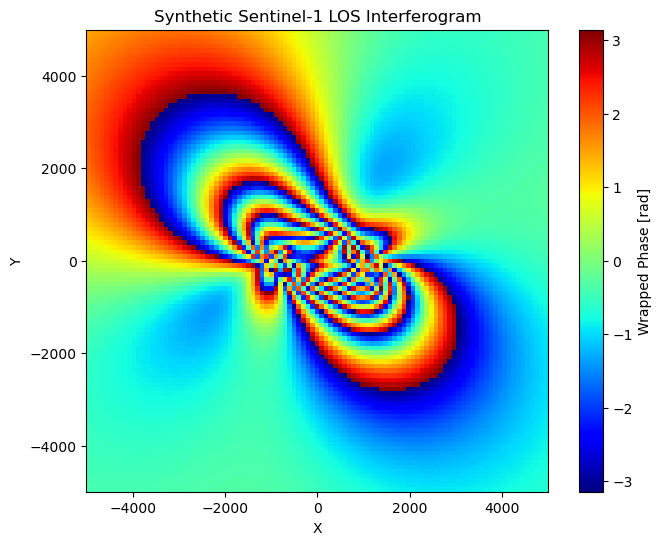

In [5]:
# Assume satellite geometry
theta_deg = 35       # Incidence angle
heading_deg = -135   # Heading angle
theta = np.deg2rad(theta_deg)
phi = np.deg2rad(90 - heading_deg)
wavelength_s1 = 0.055  # Sentinel-1 C-band wavelength in meters

# LOS vector components
los_vector = np.array([
    -np.sin(theta) * np.sin(phi),  # East
    -np.sin(theta) * np.cos(phi),  # North
    np.cos(theta)                  # Up
])

# LOS projection
los_disp = e * los_vector[0] + n * los_vector[1] + u * los_vector[2]

# Interferometric phase
phase = (4 * np.pi / wavelength_s1) * los_disp  # radians

# Optional: wrap phase to [-π, π]
wrapped_phase = np.angle(np.exp(1j * phase))

# Visualization
plt.figure(figsize=(8, 6))
plt.imshow(wrapped_phase, cmap='jet', extent=[-X_range, X_range, -Y_range, Y_range],
           vmin=-np.pi, vmax=np.pi)

plt.colorbar(label='Wrapped Phase [rad]')
plt.title('Synthetic Sentinel-1 LOS Interferogram')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Then the normal fault scenario

Fault Length: 20000.0 m
Fault Width: 15000.0 m
Depth to Fault Center: 6495.190528383289 m
Slip Vector (strike, dip, tensile): 0.000, -1.000, 0.000


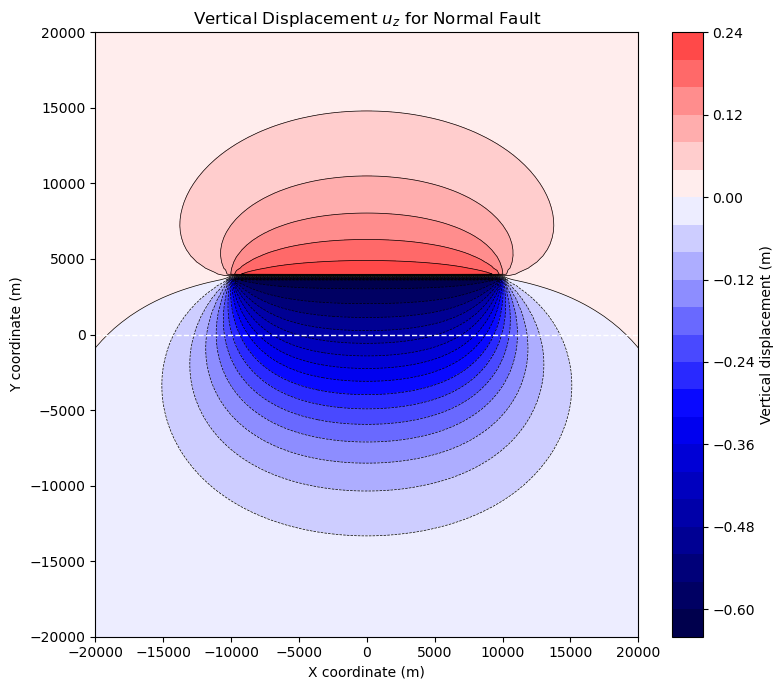

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import okada_wrapper

# Elastic constants and alpha (same as before, using ν ≈ 0.25)
lambda_ = 3e10
mu = 3e10
alpha = (lambda_ + mu) / (lambda_ + 2 * mu)

# Fault parameters for a normal fault
strike = 90.0    # fault oriented E-W
dip = 60.0       # dipping fault (60° from horizontal)
rake = -90.0     # slip is pure normal (dip-slip down)
slip = 1.0       # slip magnitude (m)

fault_length = 20000.0   # 20 km total length
fault_width  = 15000.0   # 15 km down-dip extent
# Depth to fault center (vertical): half the vertical extent of the fault
# Vertical extent = fault_width * sin(dip)
vertical_extent = fault_width * np.sin(np.radians(dip))
depth = vertical_extent / 2.0  # center depth (top at surface, bottom at vertical_extent)

# Slip vector components from rake (rake = -90° gives pure dip-slip downward)
strike_slip = slip * np.cos(np.radians(rake))   # will be 0 since cos(-90)=0
dip_slip    = slip * np.sin(np.radians(rake))   # = -1.0 (down-dip slip)
tensile_slip = 0.0
slip_vector = [strike_slip, dip_slip, tensile_slip]  # e.g., [0.0, -1.0, 0.0]

# Print fault parameters
print(f"Fault Length: {fault_length} m")
print(f"Fault Width: {fault_width} m")
print(f"Depth to Fault Center: {depth} m")

# Print slip vector with float formatting of 3 decimal places
print(f"Slip Vector (strike, dip, tensile): "
      f"{strike_slip:.3f}, {dip_slip:.3f}, {tensile_slip:.3f}")

# Observation grid (surface points)
nobs = 101
X_range = 20000.0  # ±20 km
Y_range = 20000.0  # ±20 km
xs = np.linspace(-X_range, X_range, nobs)
ys = np.linspace(-Y_range, Y_range, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obs_pts = np.vstack([obsx.ravel(), obsy.ravel(), np.zeros_like(obsx).ravel()]).T

displacements = np.empty_like(obs_pts)
for i in range(obs_pts.shape[0]):
    success, U, _ = okada_wrapper.dc3dwrapper(
        alpha,
        obs_pts[i].tolist(),
        depth,
        dip,
        [-fault_length/2, fault_length/2],   # along-strike from center (±10 km)
        [-fault_width/2, fault_width/2],     # along-dip from center (±7.5 km)
        slip_vector
    )
    assert success == 0
    displacements[i] = U

disp_grid = displacements.reshape(nobs, nobs, 3)
e = disp_grid[:, :, 0]
n = disp_grid[:, :, 1]
u = disp_grid[:, :, 2]

# Plot vertical displacement for normal fault
plt.figure(figsize=(8, 7))
levels = 21
cntf = plt.contourf(obsx, obsy, u, levels=levels, cmap='seismic',
                    vmin=-abs(u).max(), vmax=abs(u).max())
plt.contour(obsx, obsy, u, levels=levels, colors='k', linewidths=0.5)
plt.colorbar(cntf, label="Vertical displacement (m)")
plt.title("Vertical Displacement $u_z$ for Normal Fault")
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
# Mark fault trace: since fault dips north, surface trace runs along x-axis (y=0)
plt.axhline(0, color='w', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

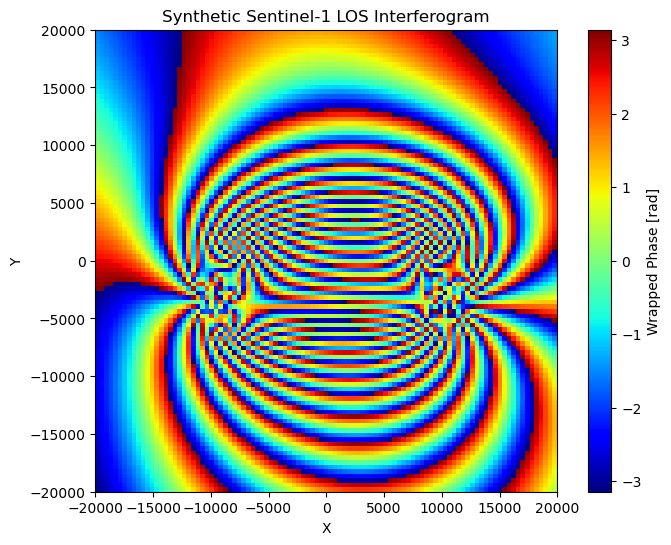

In [7]:
# Assume satellite geometry
theta_deg = 35       # Incidence angle
heading_deg = -135   # Heading angle
theta = np.deg2rad(theta_deg)
phi = np.deg2rad(90 - heading_deg)
wavelength_s1 = 0.055  # Sentinel-1 C-band wavelength in meters

# LOS vector components
los_vector = np.array([
    -np.sin(theta) * np.sin(phi),  # East
    -np.sin(theta) * np.cos(phi),  # North
    np.cos(theta)                  # Up
])

# LOS projection
los_disp = e * los_vector[0] + n * los_vector[1] + u * los_vector[2]

# Interferometric phase
phase = (4 * np.pi / wavelength_s1) * los_disp  # radians

# Optional: wrap phase to [-π, π]
wrapped_phase = np.angle(np.exp(1j * phase))

# Visualization
plt.figure(figsize=(8, 6))
plt.imshow(wrapped_phase, cmap='jet', extent=[-X_range, X_range, -Y_range, Y_range],
           vmin=-np.pi, vmax=np.pi)

plt.colorbar(label='Wrapped Phase [rad]')
plt.title('Synthetic Sentinel-1 LOS Interferogram')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()